In [43]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

def clean_pbp_data(pbp):
    pbp = pbp[(pbp['play_type']=='pass')|(pbp['play_type']=='run')]
    base_cols = pd.read_csv("https://raw.githubusercontent.com/ryanblueberry/data/main/base_cols.csv",header=None)[0]
    pbp = pbp[base_cols]
    pbp.loc[pbp['posteam_type']=='home', 'team_total'] = (
        pbp['total_line']/2 + pbp['spread_line']/2)
    pbp.loc[pbp['posteam_type']=='away', 'team_total'] = (pbp['total_line']/2 - pbp['spread_line']/2)
    return pbp

def create_pass_pbp(pbp):
    pbp_pass = pbp[pbp['play_type']=='pass']
    pbp_pass['qb_pts'] = (pbp_pass['passing_yards']*0.04 
                          + pbp_pass['touchdown']*4
                          + pbp_pass['fumble_lost'] * -1
                          + pbp_pass['interception']*-1)
    pbp_pass['rec_pts'] = (pbp_pass['touchdown']*6
                           + pbp_pass['complete_pass'] * 0.5
                           + pbp_pass['receiving_yards']*0.1)
    pbp_pass.loc[pbp_pass['two_point_conv_result'] == 'success', 'qb_pts'] = 2
    pbp_pass.loc[pbp_pass['two_point_conv_result'] == 'success', 'rec_pts'] = 2
    #adds offensive epa per play on passing plays up to that week in the season
    off_epa_by_week = pbp_pass.groupby(['posteam','season','week'],as_index = False).agg({'epa':'sum','game_id':'count'})
    off_epa_by_week['cumsum_epa'] = off_epa_by_week.groupby(['posteam','season'])['epa'].cumsum()
    off_epa_by_week['cumsum_plays'] = off_epa_by_week.groupby(['posteam','season'])['game_id'].cumsum()
    off_epa_by_week['off_epa_pp'] = (off_epa_by_week['cumsum_epa']/off_epa_by_week['cumsum_plays'])
    #adds defensive epa per play for defensive team on passing plays up to that week in the season
    def_epa_by_week = pbp_pass.groupby(['defteam','season','week'],as_index = False).agg({'epa':'sum','game_id':'count'})
    def_epa_by_week['cumsum_epa'] = def_epa_by_week.groupby(['defteam','season'])['epa'].cumsum()
    def_epa_by_week['cumsum_plays'] = def_epa_by_week.groupby(['defteam','season'])['game_id'].cumsum()
    def_epa_by_week['def_epa_pp'] = (def_epa_by_week['cumsum_epa']/def_epa_by_week['cumsum_plays'])

    pbp_pass = pd.merge(pbp_pass, off_epa_by_week[['posteam','season','week','off_epa_pp']], how = 'left', on= ['posteam','week','season'])
    pbp_pass = pd.merge(pbp_pass, def_epa_by_week[['defteam','season','week','def_epa_pp']], how = 'left', on= ['defteam','week','season'])
    
    pbp_pass.loc[pbp_pass['air_yards']>= pbp_pass['yardline_100'],'endzone_target'] = 1
    pbp_pass['endzone_target'].fillna(0, inplace = True)
    pbp_pass['down'].fillna(4,inplace = True)
    pbp_pass['air_yards'].fillna(0,inplace=True)
    pbp_pass['qb_pts'] = pbp_pass['qb_pts'].fillna(0)
    pbp_pass['rec_pts'] = pbp_pass['rec_pts'].fillna(0)
    pbp_pass['pass_location'].fillna('unk',inplace = True)
    return pbp_pass

def create_rush_pbp(pbp):
    pbp_rush = pbp[pbp['play_type']=='run']
    pbp_rush['rush_pts'] = (pbp_rush['fumble_lost'] * -1
                           + pbp_rush['rushing_yards']*0.1
                           +pbp_rush['touchdown']*6)
    pbp_rush.loc[pbp_rush['two_point_conv_result'] == 'success', 'rush_pts'] = 2
    
    #adds offensive epa per play on rushing plays up to that week in the season
    off_epa_by_week = pbp_rush.groupby(['posteam','season','week'],as_index = False).agg({'epa':'sum','game_id':'count'})
    off_epa_by_week['cumsum_epa'] = off_epa_by_week.groupby(['posteam','season'])['epa'].cumsum()
    off_epa_by_week['cumsum_plays'] = off_epa_by_week.groupby(['posteam','season'])['game_id'].cumsum()
    off_epa_by_week['off_epa_pp'] = (off_epa_by_week['cumsum_epa']/off_epa_by_week['cumsum_plays'])
    #adds defensive epa per play for defensive team on rushing plays up to that week in the season
    def_epa_by_week = pbp_rush.groupby(['defteam','season','week'],as_index = False).agg({'epa':'sum','game_id':'count'})
    def_epa_by_week['cumsum_epa'] = def_epa_by_week.groupby(['defteam','season'])['epa'].cumsum()
    def_epa_by_week['cumsum_plays'] = def_epa_by_week.groupby(['defteam','season'])['game_id'].cumsum()
    def_epa_by_week['def_epa_pp'] = (def_epa_by_week['cumsum_epa']/def_epa_by_week['cumsum_plays'])

    pbp_rush = pd.merge(pbp_rush, off_epa_by_week[['posteam','season','week','off_epa_pp']], how = 'left', on= ['posteam','week','season'])
    pbp_rush = pd.merge(pbp_rush, def_epa_by_week[['defteam','season','week','def_epa_pp']], how = 'left', on= ['defteam','week','season'])
    
    pbp_rush['down'].fillna(4,inplace=True)
    pbp_rush['rush_pts'].fillna(0, inplace = True)
    pbp_rush['run_gap'].fillna('unk',inplace = True)
    pbp_rush['run_location'].fillna('unk',inplace=True)
    return pbp_rush
    
def make_pbps(pbp):
    pbp = clean_pbp_data(pbp)
    pbp_rush = create_rush_pbp(pbp)
    pbp_pass = create_pass_pbp(pbp)
    return pbp_rush, pbp_pass
    
def create_rush_model_inputs(pbp_rush):
    rush_model_cols = pd.read_csv(
        'https://raw.githubusercontent.com/ryanblueberry/data/main/run_model_cols.csv'
        , header = None)[0]
    X = pbp_rush[rush_model_cols]
    y = pbp_rush['rush_pts']
    return X,y

def create_qb_model_inputs(pbp_pass):
    pass_model_cols = pd.read_csv(
        "https://raw.githubusercontent.com/ryanblueberry/data/main/pass_model_cols.csv"
        , header=None)[0]
    X = pbp_pass[pass_model_cols]
    y = pbp_pass['qb_pts']
    return X,y

def create_rec_model_inputs(pbp_pass):
    pass_model_cols = pd.read_csv(
        "https://raw.githubusercontent.com/ryanblueberry/data/main/pass_model_cols.csv"
        , header=None)[0]
    X = pbp_pass[pass_model_cols]
    y = pbp_pass['rec_pts']
    return X,y
    
def create_qb_model(pbp_pass):
    X,y = create_qb_model_inputs(pbp_pass)
    x_train, x_test, y_qb_train, y_qb_test = train_test_split(X, y,
                                                              test_size = 0.25,
                                                              random_state = 22)
    regr = RandomForestRegressor(max_depth = 3, random_state = 22)
    regr.fit(x_train,y_qb_train)
    pred = regr.predict(x_test)
    pred = pd.DataFrame(pred,columns = ['preds']).set_index(x_test.index)
    pred = pred.join(pbp_pass[['game_id','season_type','week','posteam',
                               'passer_player_id','passer_player_name',
                               'qb_pts']])
    return regr, pred
    
def create_rec_model(pbp_pass):
    X,y = create_rec_model_inputs(pbp_pass)
    x_train, x_test, y_rec_train, y_rec_test = train_test_split(X, y,
                                                              test_size = 0.25,
                                                              random_state = 22)    
    regr = RandomForestRegressor(max_depth = 3, random_state = 22)
    regr.fit(x_train,y_rec_train)
    pred = regr.predict(x_test)
    pred = pd.DataFrame(pred,columns = ['preds']).set_index(x_test.index)
    pred = pred.join(pbp_pass[['game_id','season_type','week','posteam',
                               'receiver_player_id','receiver_player_name',
                               'rec_pts']])
    return regr, pred

def create_rush_model(pbp_rush):
    X,y = create_rush_model_inputs(pbp_rush)
    x_train, x_test, y_rush_train, y_rush_test = train_test_split(X, y,
                                                              test_size = 0.25,
                                                              random_state = 22) 
    regr = RandomForestRegressor(max_depth = 3,random_state = 22)
    regr.fit(x_train,y_rush_train)
    pred = regr.predict(x_test)
    pred = pd.DataFrame(pred,columns = ['preds']).set_index(x_test.index)
    pred = pred.join(pbp_rush[['game_id','season_type','week','posteam',
                               'rusher_player_id','rusher_player_name',
                               'rush_pts']])
    return regr, pred

def create_exp_pts_pg(*args):
    preds = pd.DataFrame(columns = ['preds', 'game_id', 'season_type', 'week', 
                                    'posteam','player_id', 'player_name', 'pts'])
    for n in args:
        n.columns = ['preds', 'game_id', 'season_type', 'week', 'posteam',
           'player_id', 'player_name', 'pts']
        preds = pd.concat([preds,n])
    preds = preds.groupby(['player_id','game_id'],as_index= False).agg(
                                                        {'player_name':'last',
                                                        'pts':'sum',
                                                        'preds':'sum'})
    return preds


def get_preds_year(pbp_train,pbp_test):
    pbp_train = clean_pbp_data(pbp_train)

    pbp_pass = create_pass_pbp(pbp_train)
    pbp_rush = create_rush_pbp(pbp_train)

    qb_model, qb_preds = create_qb_model(pbp_pass)
    rec_model, rec_preds = create_rec_model(pbp_pass)
    rush_model, rush_preds = create_rush_model(pbp_rush)
    
    pbp_test = clean_pbp_data(pbp_test)
    pbp_rush, pbp_pass = make_pbps(pbp_test)
    X_rush, y_rush = create_rush_model_inputs(pbp_rush)
    X_qb, y_qb = create_qb_model_inputs(pbp_pass)
    X_rec, y_rec = create_rec_model_inputs(pbp_pass)
    
    #need to join with inputs column
    qb_preds = qb_model.predict(X_qb)
    qb_preds = pd.DataFrame(qb_preds,columns = ['preds']).set_index(X_qb.index)
    qb_preds = qb_preds.join(pbp_pass[['game_id','season_type','week','posteam',
                               'passer_player_id','passer_player_name',
                               'qb_pts']])
    rush_preds = rush_model.predict(X_rush)
    rush_preds = pd.DataFrame(rush_preds,columns = ['preds']).set_index(X_rush.index)
    rush_preds = rush_preds.join(pbp_rush[['game_id','season_type','week','posteam',
                               'rusher_player_id','rusher_player_name',
                               'rush_pts']])
    rec_preds = rec_model.predict(X_rec)
    rec_preds = pd.DataFrame(rec_preds,columns = ['preds']).set_index(X_rec.index)
    rec_preds = rec_preds.join(pbp_pass[['game_id','season_type','week','posteam',
                               'receiver_player_id','receiver_player_name',
                               'rec_pts']])
    ids = nfl.import_ids()[['gsis_id','position']].dropna().rename(columns={'gsis_id':'player_id'})
    preds = create_exp_pts_pg(qb_preds,rush_preds,rec_preds)
    preds = preds.merge(ids, how = 'left',on = 'player_id')
    preds = preds.dropna()
    return preds

In [2]:
pbp_2023 = nfl.import_pbp_data(range(2023,2024),downcast = True)
pbp = nfl.import_pbp_data(range(2018,2023),downcast = True)

2023 done.
Downcasting floats.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [7]:
vals = get_preds_year(pbp,pbp_2023)

In [59]:
print("""Per player per game expected fantasy points vs. actual fantasy points:
      """)
vals['pts'] = vals['pts'].astype(np.float64)
vals['preds'] = vals['preds'].astype(np.float64)
vals = vals[(vals['position'] =='QB')|(vals['position'] =='RB')|(vals['position'] =='WR')|(vals['position'] =='TE')]
vals

Per player per game expected fantasy points vs. actual fantasy points:
      


,player_id,game_id,player_name,pts,preds,position
0,00-0023459,2023_01_BUF_NYJ,A.Rodgers,0.000000,0.863649,QB
1,00-0024243,2023_04_DEN_CHI,M.Lewis,1.300000,0.916613,TE
2,00-0026498,2023_01_LA_SEA,M.Stafford,14.460000,20.982897,QB
3,00-0026498,2023_02_SF_LA,M.Stafford,17.979999,22.491638,QB
4,00-0026498,2023_03_LA_CIN,M.Stafford,15.460000,19.709904,QB
...,...,...,...,...,...,...
1532,00-0039164,2023_05_TEN_IND,A.Richardson,4.420000,6.168117,QB
1533,00-0039165,2023_01_LA_SEA,Z.Charbonnet,1.100000,1.829606,RB
1534,00-0039165,2023_02_SEA_DET,Z.Charbonnet,4.000000,5.075816,RB
1535,00-0039165,2023_03_CAR_SEA,Z.Charbonnet,5.000000,8.305367,RB


# Intro to expected fantasy points
Creating an expected points model for fantasy football is very useful as the first place to check-in on how often players are being used.  If a player is not getting the ball, they will not accumulate the traditional statistics that fantasy points are based on. Therefore, usage in fantasy football is a very important factor in whether or not a player will score fantasy points.

# Distribution of fantasy points
Due to the nature of the different positions in the NFL and how fantasy football is scored there are different distributions for each different role in the play.  
## Rushing distribution
For rushing a distribution centered around 0 can be seen, with some numbers distributed as negative as -2. This is because it is possible to get negative rushing yards on a play. Additionally, a fumble is worth -1 points, so some of these numbers approaching -2 are plays in which disaster struck and the play was stopped far behind the line of scrimmage and fumbled on top of it.  Each yard is worth 0.1 fantasy points, so most runs are between 0- and 20-yard carries. A second, much smaller peak can be seen in the distribution around 6 points.  This is due to rushing touchdowns, which are worth 6 points, so a short run of 2 yards at the goal line are worth disproportionately more than a 2-yard carry in the middle of the field.  Bins can be seen up to around the 14-point mark, but they are very rare because it is exceedingly difficult to score a 75+ yard rushing touchdown.
## Receiving Distribution
For the receiving distribution there are a few different peaks for fantasy points scored on receptions. The high bin at 0 shows that incomplete passes make up a good portion of passing plays. The receiver gets 0 fantasy points on an incomplete pass. All receiving yards are also worth 0.1 fantasy points. The rest of the distribution is centered around 1 in part because receivers are awarded 0.5 fantasy points for catching the ball, so any values below 0.5 are where the receiver is being tackled for a loss of yards. Receivers are also less likely to fumble than rushers or passers because the receiver must fully secure the ball before fumbling, and if they don't it will just be an incomplete pass. They are also running with or holding the ball less than the rushers or passers. This is also why the third peak of the distribution is centered around 6.5 points instead of 6, the receiver must catch the ball to get a touchdown on a receiving play.  Like the rushing distribution there are a few bins between 12 and 14 points, but these plays are exceedingly difficult, so they do not occur often.
## Passing Distribution
The passing distribution is much tighter than the distribution for rushers or receivers.  This is due to the passer only getting 0.04 fantasy point per passing yard, and 4 points for passing touchdowns. Like the rushing distribution the passing distribution goes into the negative, this is again due to fumbles as passers can be hit while holding the ball. There is a second peak in the distribution around 4 points due to the fantasy point value of a passing touchdown. The distribution only reaches a high near 7, because the yards and touchdowns are worth less, so the maximum score is lower when passing the ball.

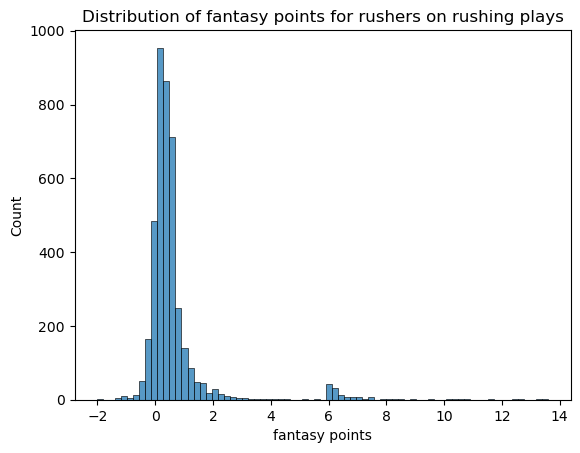

In [9]:
rush_pbp_2023, pass_pbp_2023 = make_pbps(pbp_2023)
fig, ax = plt.subplots()
sns.histplot(data = rush_pbp_2023, x = 'rush_pts', bins = 75)
ax.set_xlabel('fantasy points')
ax.set_title("Distribution of fantasy points for rushers on rushing plays");

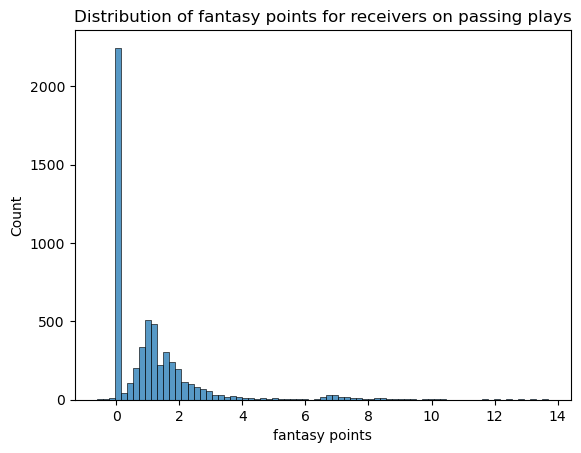

In [10]:
fig, ax = plt.subplots()
sns.histplot(data = pass_pbp_2023, x = 'rec_pts',bins = 75)
ax.set_xlabel('fantasy points')
ax.set_title("Distribution of fantasy points for receivers on passing plays");

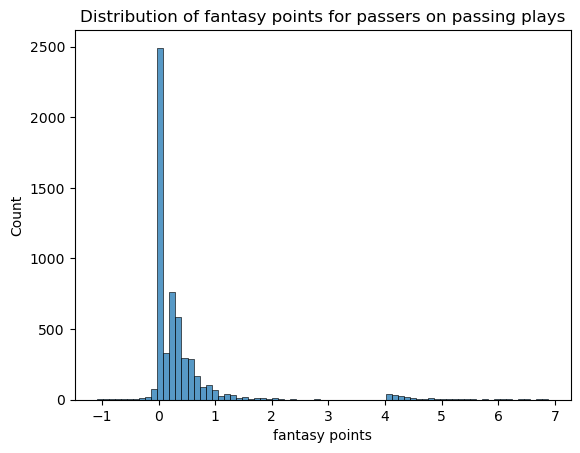

In [11]:
fig, ax = plt.subplots()
sns.histplot(data = pass_pbp_2023, x = 'qb_pts',bins = 75)
ax.set_xlabel('fantasy points')
ax.set_title("Distribution of fantasy points for passers on passing plays");

# Model Features
As shown in the distribution of plays above, different types of plays have an influence on how many fantasy points are scored on an individual play. The weights of the features also reflect this, where the yardline a player is on for a rush heavily impacts the expected fantasy points, while it does not have as much of an effect for passers or receivers.

In [12]:
rush_pbp,pass_pbp = make_pbps(pbp)
qb_model, qb_preds = create_qb_model(pass_pbp)
rec_model, rec_preds = create_rec_model(pass_pbp)
rush_model, rush_preds = create_rush_model(rush_pbp)
X_qb,y_qb = create_qb_model_inputs(pass_pbp)
X_rec, y_rec = create_rec_model_inputs(pass_pbp)
X_rush, y_rush = create_rush_model_inputs(rush_pbp)
pass1 = pd.DataFrame([list(qb_model.feature_importances_)],columns = list(X_qb.columns),index = ['Passer model weights'])
rec = pd.DataFrame([list(rec_model.feature_importances_)],columns = list(X_rec.columns),index = ['Reception model weights'])
rush = pd.DataFrame([list(rush_model.feature_importances_)],columns = list(X_rush.columns),index = ['Rush model weights'])
print('Number of features in pass model: ' + str(len(rec_model.feature_importances_)))
print('Number of features in rush model: ' + str(len(rush_model.feature_importances_)))

Number of features in pass model: 11
Number of features in rush model: 12


In [13]:
pass1

,yardline_100,half_seconds_remaining,goal_to_go,ydstogo,air_yards,play_clock,total_line,team_total,off_epa_pp,def_epa_pp,endzone_target
Passer model weights,0.170332,0.001839,0.000159,0.003478,0.175651,0.000239,0.0,0.002104,0.022621,0.005742,0.617836


In [14]:
rec

,yardline_100,half_seconds_remaining,goal_to_go,ydstogo,air_yards,play_clock,total_line,team_total,off_epa_pp,def_epa_pp,endzone_target
Reception model weights,0.111595,0.004826,0.001214,0.0068,0.304853,0.000435,0.000324,0.003526,0.062327,0.01235,0.491751


In [15]:
rush

,yardline_100,half_seconds_remaining,down,ydstogo,no_huddle,qb_scramble,two_point_attempt,play_clock,total_line,team_total,off_epa_pp,def_epa_pp
Rush model weights,0.930658,0.000651,0.000377,0.005532,0.000306,0.045082,0.005472,0.000146,0.000263,0.000268,0.008013,0.003231


In [53]:
vals_gb = vals.groupby('player_id', as_index = False).agg(player_name = ('player_name','last'),
                                                          position = ('position','last'),
                                                          avg_pts = ('pts',np.mean),
                                                          avg_pred = ('preds', np.mean),
                                                          games = ('preds','count'))

# Comparing Actual Fantasy Points to Expected
These scatterplots compare the predicted fantasy points scored to actual fantasy points scored. For the top 5 charts each point is a singular game, while the lower 5 charts display player's averages over the number of games they have played.  There is clear correlation between expected and actual fantasy points.  The correlation is even stronger when using the average of a players expected and actual points because the average smooths out outlier performances in games that are more difficult to accomplish over the course of a season.

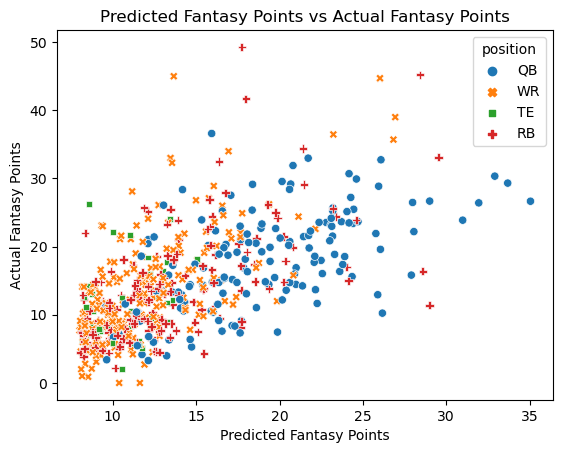

In [78]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals[(vals['preds']> 8.0)], x = 'preds', y = 'pts', hue = 'position',style = 'position')
#sns.regplot(data = vals[(vals['preds']> 8.0) & (vals['position'] == 'QB')],x = 'preds', y = 'pts',scatter = False, ax = ax)
ax.set_xlabel('Predicted Fantasy Points')
ax.set_ylabel('Actual Fantasy Points')
ax.set_title('Predicted Fantasy Points vs Actual Fantasy Points');

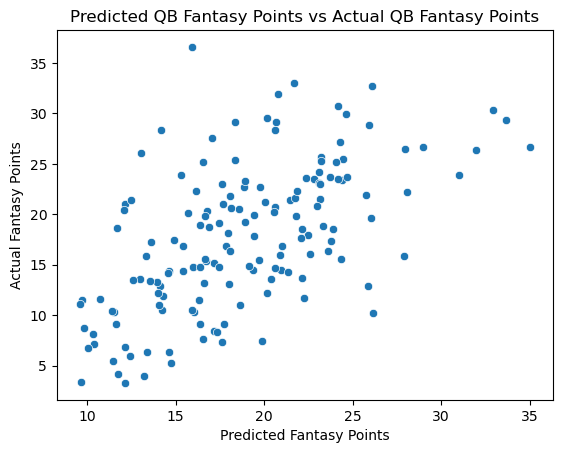

In [64]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals[(vals['preds']> 8.0) & (vals['position'] == 'QB')], x = 'preds', y = 'pts')
#sns.regplot(data = vals[(vals['preds']> 8.0) & (vals['position'] == 'QB')],x = 'preds', y = 'pts',scatter = False, ax = ax)
ax.set_xlabel('Predicted Fantasy Points')
ax.set_ylabel('Actual Fantasy Points')
ax.set_title('Predicted QB Fantasy Points vs Actual QB Fantasy Points');

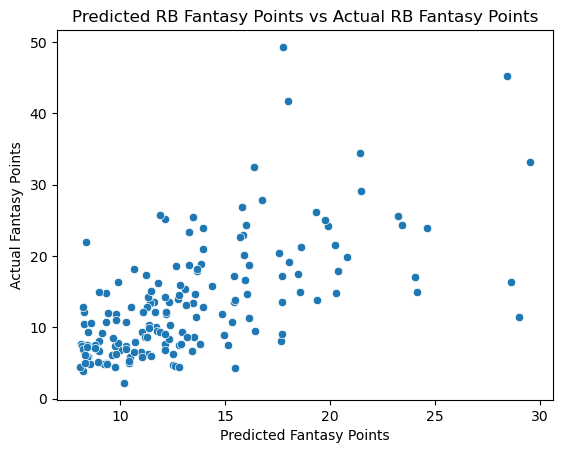

In [65]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals[(vals['preds']> 8) & (vals['position'] == 'RB')], x = 'preds', y = 'pts')
#sns.regplot(data = vals[(vals['preds']> 8) & (vals['position'] == 'RB')],x = 'preds', y = 'pts',scatter = False, ax = ax)
ax.set_xlabel('Predicted Fantasy Points')
ax.set_ylabel('Actual Fantasy Points')
ax.set_title('Predicted RB Fantasy Points vs Actual RB Fantasy Points');

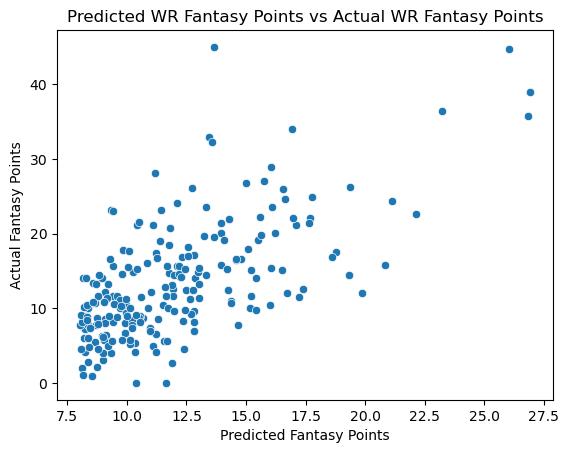

In [66]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals[(vals['preds']> 8) & (vals['position'] == 'WR')], x = 'preds', y = 'pts')
#sns.regplot(data = vals[(vals['preds']> 8) & (vals['position'] == 'WR')],x = 'preds', y = 'pts',scatter = False, ax = ax)
ax.set_xlabel('Predicted Fantasy Points')
ax.set_ylabel('Actual Fantasy Points')
ax.set_title('Predicted WR Fantasy Points vs Actual WR Fantasy Points');

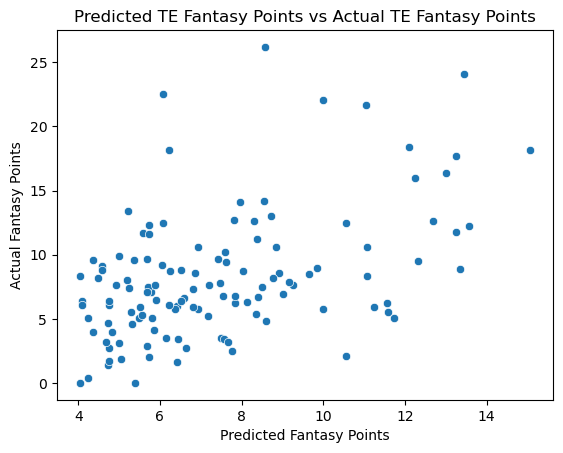

In [67]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals[(vals['preds']> 4) & (vals['position'] == 'TE')], x = 'preds', y = 'pts')
#sns.regplot(data = vals[(vals['preds']> 4) & (vals['position'] == 'TE')],x = 'preds', y = 'pts',scatter = False, ax = ax)
ax.set_xlabel('Predicted Fantasy Points')
ax.set_ylabel('Actual Fantasy Points')
ax.set_title('Predicted TE Fantasy Points vs Actual TE Fantasy Points');

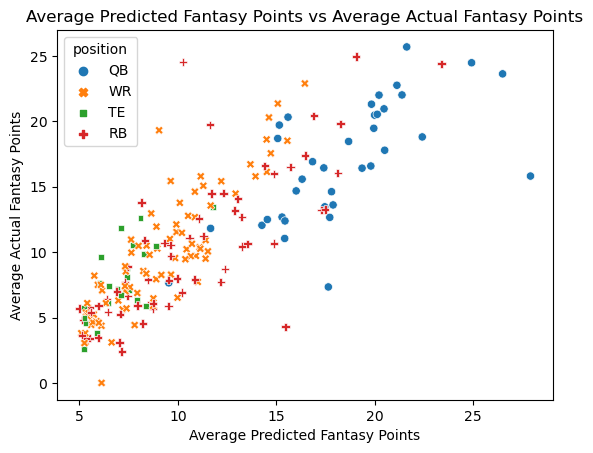

In [70]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals_gb[vals_gb['avg_pred']> 5], x = 'avg_pred', y = 'avg_pts', hue = 'position', style = 'position')
#sns.regplot(data = vals_gb, x = 'avg_pred', y = 'avg_pts',scatter = False, ax = ax)
ax.set_xlabel('Average Predicted Fantasy Points')
ax.set_ylabel('Average Actual Fantasy Points')
ax.set_title('Average Predicted Fantasy Points vs Average Actual Fantasy Points');

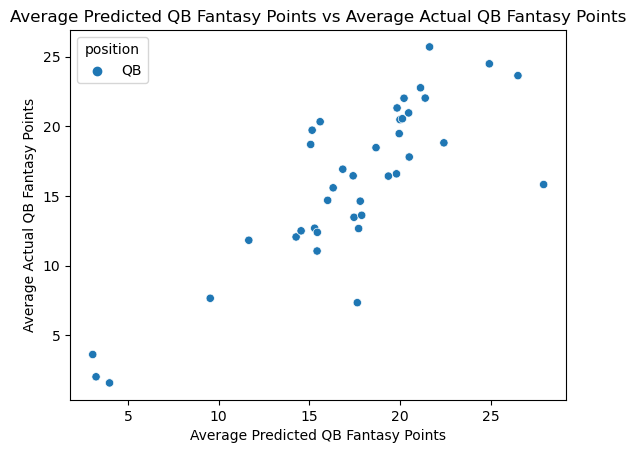

In [73]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals_gb[(vals_gb['avg_pred']> 3) & (vals_gb['position'] == 'QB')], x = 'avg_pred', y = 'avg_pts', hue = 'position', style = 'position')
#sns.regplot(data = vals_gb, x = 'avg_pred', y = 'avg_pts',scatter = False, ax = ax)
ax.set_xlabel('Average Predicted QB Fantasy Points')
ax.set_ylabel('Average Actual QB Fantasy Points')
ax.set_title('Average Predicted QB Fantasy Points vs Average Actual QB Fantasy Points');

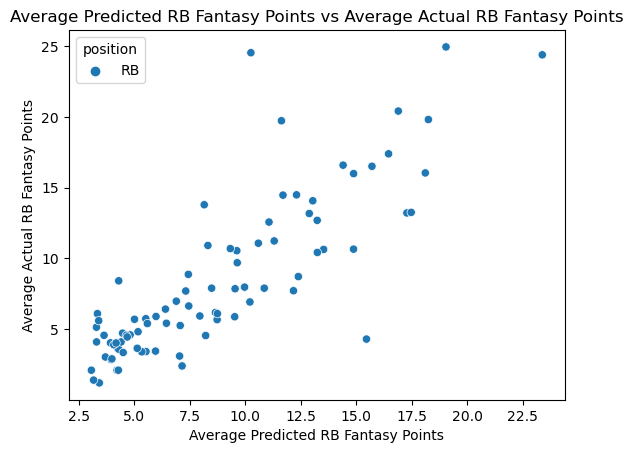

In [74]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals_gb[(vals_gb['avg_pred']> 3) & (vals_gb['position'] == 'RB')], x = 'avg_pred', y = 'avg_pts', hue = 'position', style = 'position')
#sns.regplot(data = vals_gb, x = 'avg_pred', y = 'avg_pts',scatter = False, ax = ax)
ax.set_xlabel('Average Predicted RB Fantasy Points')
ax.set_ylabel('Average Actual RB Fantasy Points')
ax.set_title('Average Predicted RB Fantasy Points vs Average Actual RB Fantasy Points');

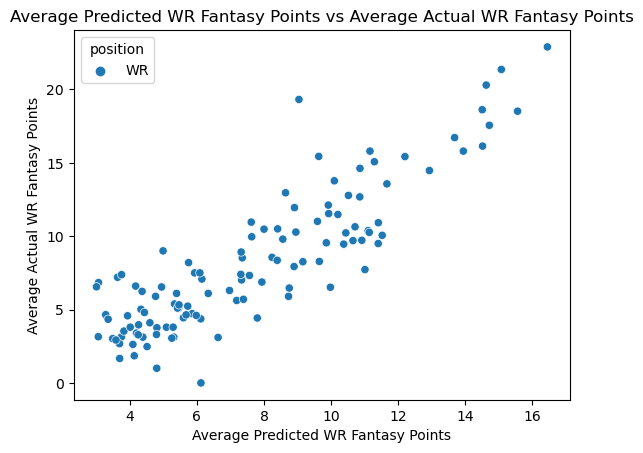

In [75]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals_gb[(vals_gb['avg_pred']> 3) & (vals_gb['position'] == 'WR')], x = 'avg_pred', y = 'avg_pts', hue = 'position', style = 'position')
#sns.regplot(data = vals_gb, x = 'avg_pred', y = 'avg_pts',scatter = False, ax = ax)
ax.set_xlabel('Average Predicted WR Fantasy Points')
ax.set_ylabel('Average Actual WR Fantasy Points')
ax.set_title('Average Predicted WR Fantasy Points vs Average Actual WR Fantasy Points');

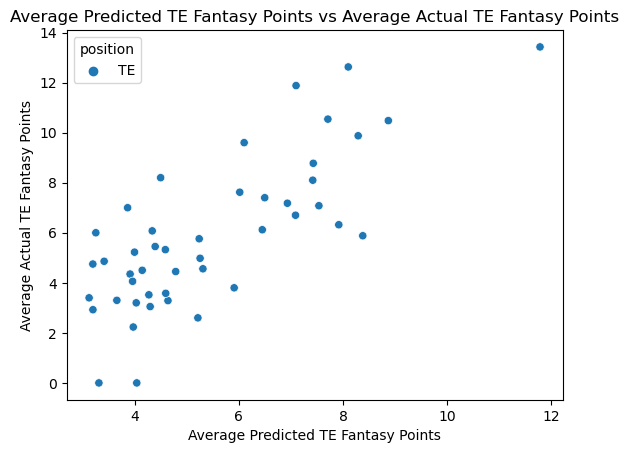

In [76]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = vals_gb[(vals_gb['avg_pred']> 3) & (vals_gb['position'] == 'TE')], x = 'avg_pred', y = 'avg_pts', hue = 'position', style = 'position')
#sns.regplot(data = vals_gb, x = 'avg_pred', y = 'avg_pts',scatter = False, ax = ax)
ax.set_xlabel('Average Predicted TE Fantasy Points')
ax.set_ylabel('Average Actual TE Fantasy Points')
ax.set_title('Average Predicted TE Fantasy Points vs Average Actual TE Fantasy Points');